<a href="https://colab.research.google.com/github/Nico25041/AI-Image-Classification-Base-CNN-ResNet50/blob/main/AI_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download Dataset
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [2]:

# Load train and test datasets
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load entire training set
full_train_dataset = datasets.ImageFolder("/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train", transform=transform)

#Split given training set into 90% training set, 10% validation set
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#Create test data set
test_dataset = datasets.ImageFolder(root='/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test', transform=transform)

#Set up data loaders
train_dataloader = DataLoader(train_dataset, batch_size= 64, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=8)


In [3]:
import torch.nn.functional as F
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np

#Initialize CNN block
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
import os

#Save function
#saves the state in folder expressing which epoch it was from
def save_base_checkpoint(model, epoch):
    model_folder = "base_model/checkpoint/"

    model_out_path = model_folder + "model_{}.pth".format(epoch)
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict()
    }
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    torch.save(state, model_out_path)
    sav = "Checkpoint saved to {}".format(model_out_path)

def save_resnet_checkpoint(model, epoch):
    model_folder = "resnet_model/checkpoint/"

    model_out_path = model_folder + "model_{}.pth".format(epoch)
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict()
    }
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    torch.save(state, model_out_path)
    sav = "Checkpoint saved to {}".format(model_out_path)

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = CNN().to(device)

Resnet_model = models.resnet50(pretrained=True)
num_features = Resnet_model.fc.in_features
Resnet_model.fc = nn.Linear(num_features, 2)
Resnet_model = Resnet_model.to(device)

opt_base = torch.optim.Adam(base_model.parameters(), lr=1e-4)
opt_resnet = torch.optim.Adam(Resnet_model.parameters(), lr=1e-4)

#training
epochs = 10
for epoch in range(epochs):
    base_model.train()
    Resnet_model.train()

    base_loss_value = 0
    resnet_loss_value = 0

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Base CNN
        opt_base.zero_grad()
        base_outputs = base_model(imgs)
        ce_loss = F.cross_entropy(base_outputs, labels)
        ce_loss.backward()
        opt_base.step()
        base_loss_value += ce_loss.item()

        #ResNet50
        opt_resnet.zero_grad()
        resnet_outputs = Resnet_model(imgs)
        res_loss = F.cross_entropy(resnet_outputs, labels)
        res_loss.backward()
        opt_resnet.step()
        resnet_loss_value += res_loss.item()

    #validation
    base_model.eval()
    Resnet_model.eval()

    base_correct = 0
    resnet_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            out_base = base_model(imgs)
            out_resnet = Resnet_model(imgs)

            _, pred_base = torch.max(out_base, 1)
            _, pred_resnet = torch.max(out_resnet, 1)

            total += labels.size(0)
            base_correct += (pred_base == labels).sum().item()
            resnet_correct += (pred_resnet == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Base CNN Val Acc: {100 * base_correct / total:.2f}%")
    print(f"ResNet50 Val Acc: {100 * resnet_correct / total:.2f}%")

    save_base_checkpoint(base_model, epoch)
    save_resnet_checkpoint(Resnet_model, epoch)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


Epoch 1/10
Base CNN Val Acc: 90.69%
ResNet50 Val Acc: 97.47%
Epoch 2/10
Base CNN Val Acc: 92.14%
ResNet50 Val Acc: 97.16%
Epoch 3/10
Base CNN Val Acc: 93.31%
ResNet50 Val Acc: 97.62%
Epoch 4/10
Base CNN Val Acc: 94.51%
ResNet50 Val Acc: 97.87%
Epoch 5/10
Base CNN Val Acc: 94.74%
ResNet50 Val Acc: 97.93%
Epoch 6/10
Base CNN Val Acc: 92.75%
ResNet50 Val Acc: 97.91%
Epoch 7/10
Base CNN Val Acc: 95.07%
ResNet50 Val Acc: 98.20%
Epoch 8/10
Base CNN Val Acc: 95.50%
ResNet50 Val Acc: 97.89%
Epoch 9/10
Base CNN Val Acc: 95.22%
ResNet50 Val Acc: 98.19%
Epoch 10/10
Base CNN Val Acc: 95.48%
ResNet50 Val Acc: 98.24%


In [29]:
#loading models
base_model = CNN().to(device)
checkpoint = torch.load("base_model/checkpoint/model_8.pth")
base_model.load_state_dict(checkpoint["model_state_dict"])
base_model.eval()


resnet_model = models.resnet50(pretrained=False)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model = resnet_model.to(device)

checkpoint = torch.load("resnet_model/checkpoint/model_7.pth")
resnet_model.load_state_dict(checkpoint["model_state_dict"])
resnet_model.eval()

resnet_correct = 0
base_correct = 0
total = 0

#saving every prediction for confusion matrix

all_labels = []
all_resnet_preds = []
all_base_preds = []

#comparing prediction with label, then appending for later use
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), torch.tensor(labels).to(device)
        base_outputs = base_model(imgs)
        resnet_outputs = resnet_model(imgs)
        _, base_predicted = torch.max(base_outputs, 1)
        _, resnet_predicted = torch.max(resnet_outputs, 1)
        total += labels.size(0)
        base_correct += (base_predicted == labels).sum().item()
        resnet_correct += (resnet_predicted == labels).sum().item()

        all_labels.append(labels.cpu())
        all_resnet_preds.append(resnet_predicted.cpu())
        all_base_preds.append(base_predicted.cpu())

print(f"Base Accuracy: {100 * base_correct / total:.2f}%")
print(f"ResNet50 Accuracy: {100 * resnet_correct / total:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipython-input-710377109.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs, labels = imgs.to(device), torch.tensor(labels).to(device)


Base Accuracy: 95.44%
ResNet50 Accuracy: 97.86%


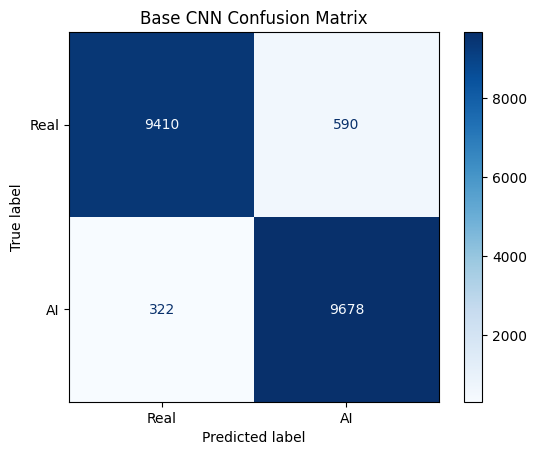

In [30]:
#Creating confusion matrix for base CNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_labels = torch.cat(all_labels).numpy()
all_base_preds = torch.cat(all_base_preds).numpy()


cm_base = confusion_matrix(all_labels, all_base_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=["Real", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Base CNN Confusion Matrix")
plt.show()

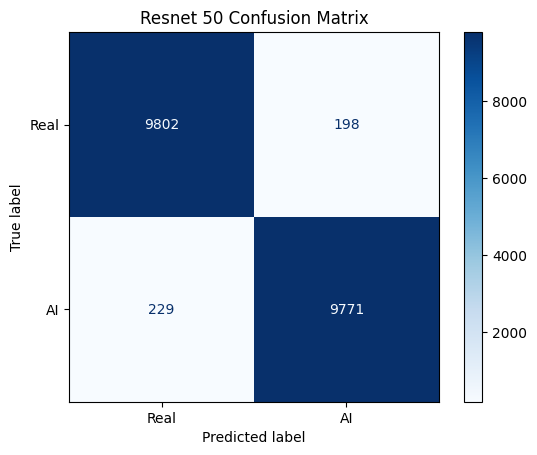

In [31]:
#Resnet 50 CM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_resnet_preds = torch.cat(all_resnet_preds).numpy()


cm_base = confusion_matrix(all_labels, all_resnet_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=["Real", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Resnet 50 Confusion Matrix")
plt.show()